In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

## 显示注释

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## 导入测试图片

In [3]:
image = cv2.imread('demo.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

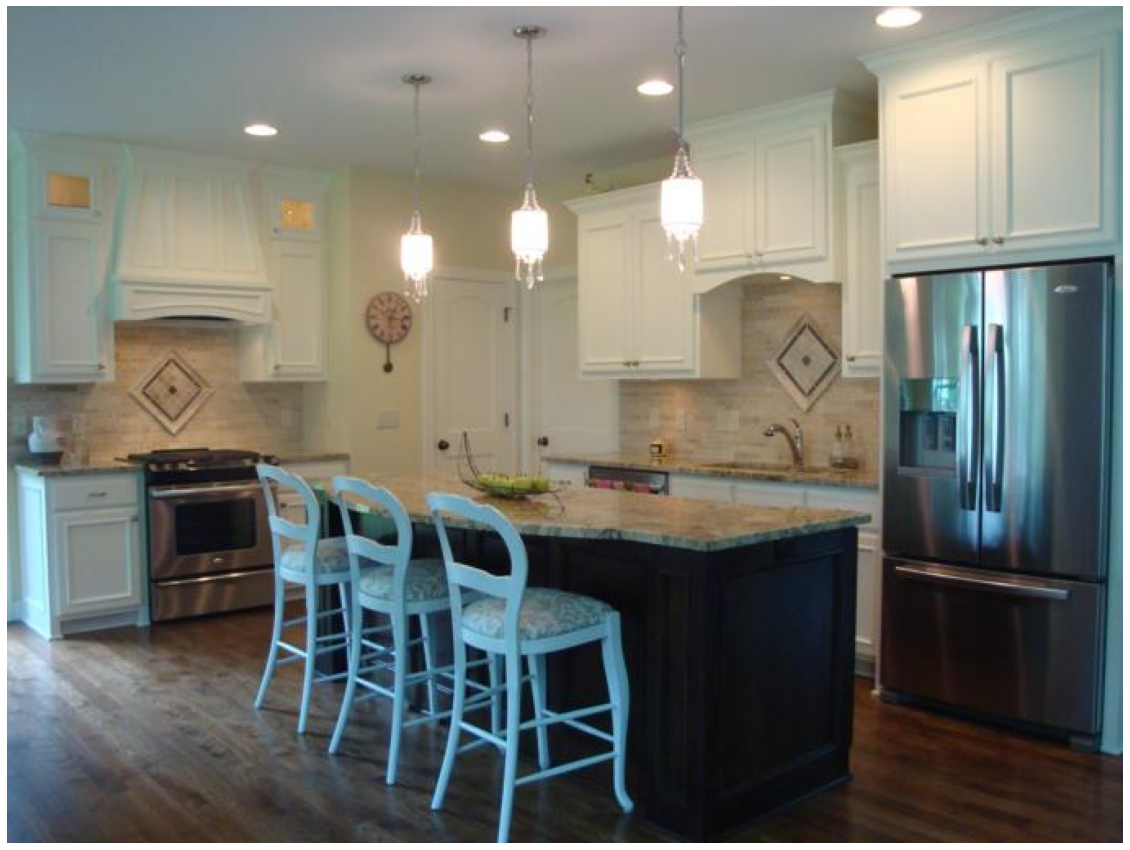

In [4]:
plt.figure(figsize = (20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

## 使用SAM模型

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint = sam_checkpoint)
sam.to(device = device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
masks = mask_generator.generate(image)

In [7]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 46478,
  'bbox': [0, 369, 682, 141],
  'predicted_iou': 1.0173600912094116,
  'point_coords': [[458.890625, 504.0]],
  'stability_score': 0.9792433381080627,
  'crop_box': [0, 0, 683, 512]},
 {'segmentation': array([[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 44323,
  'bbox': [0, 0, 624, 

## 可视化分割图像 + 预测框

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def show_ann(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse = True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
        # 绘制边界框
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
    ax.imshow(img)

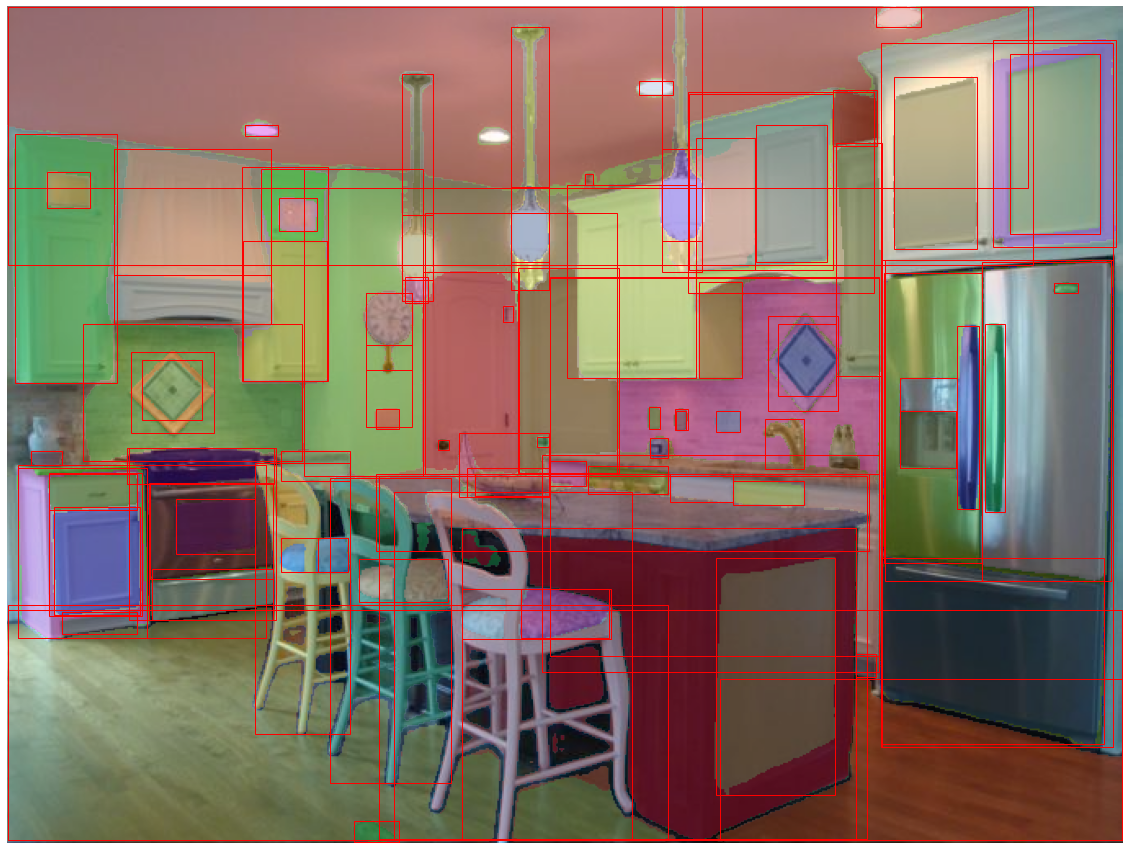

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_ann(masks)
plt.axis('off')
plt.show()

## SAM生成的框的提取

In [11]:
def extract_bboxes(anns):
    if len(anns) == 0:
        return []

    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse = True)
    bbox_list = []

    for ann in sorted_anns:
        x, y, w, h = ann['bbox']
        bbox_list.append((x, y, x + w, y + h))

    return bbox_list

In [12]:
bbox_list = extract_bboxes(masks)
bbox_list

[(0, 369, 682, 510),
 (0, 0, 627, 158),
 (0, 0, 624, 111),
 (534, 22, 676, 453),
 (535, 155, 676, 453),
 (0, 366, 404, 510),
 (227, 287, 526, 509),
 (278, 319, 519, 509),
 (537, 155, 675, 351),
 (596, 156, 675, 351),
 (436, 411, 682, 510),
 (535, 337, 671, 451),
 (255, 126, 373, 286),
 (236, 297, 382, 510),
 (536, 163, 596, 340),
 (416, 52, 530, 175),
 (332, 165, 533, 397),
 (181, 99, 254, 287),
 (4, 78, 67, 230),
 (332, 166, 533, 286),
 (603, 20, 678, 147),
 (433, 337, 506, 482),
 (65, 87, 161, 194),
 (6, 280, 158, 386),
 (417, 53, 505, 161),
 (342, 109, 421, 227),
 (74, 270, 164, 375),
 (6, 282, 85, 386),
 (197, 288, 271, 475),
 (254, 162, 313, 286),
 (46, 194, 180, 278),
 (225, 286, 527, 333),
 (327, 274, 533, 407),
 (613, 29, 668, 139),
 (86, 291, 162, 375),
 (143, 98, 196, 229),
 (312, 160, 374, 285),
 (542, 43, 593, 148),
 (151, 279, 209, 445),
 (25, 285, 82, 373),
 (87, 291, 162, 350),
 (458, 72, 501, 156),
 (507, 83, 535, 226),
 (144, 143, 195, 229),
 (28, 306, 81, 372),
 (65, 

## SAM生成的框的可视化

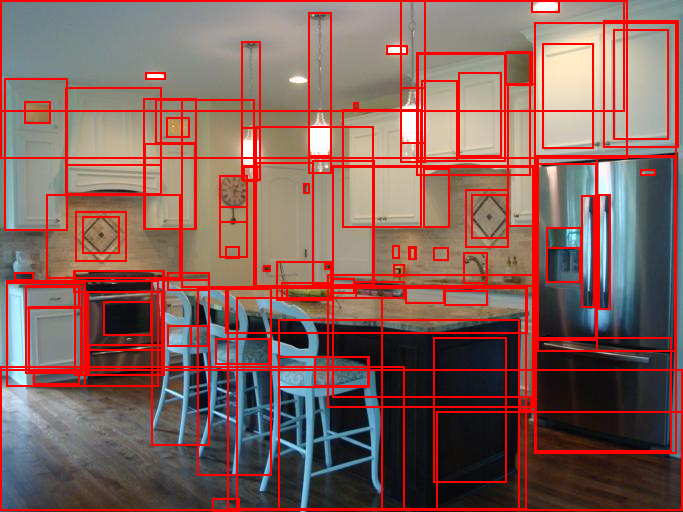

In [14]:
from PIL import Image, ImageDraw

def draw_bboxes(image, bboxes, color="red", thickness=2):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        bbox = tuple(map(int, bbox))  # 将浮点数类型的坐标转换为整数类型
        draw.rectangle(bbox, outline=color, width=thickness)
    del draw

image_path = "demo.jpg"
image = Image.open(image_path).convert("RGB")
draw_bboxes(image, bbox_list)
image.show()

## GT框的测试

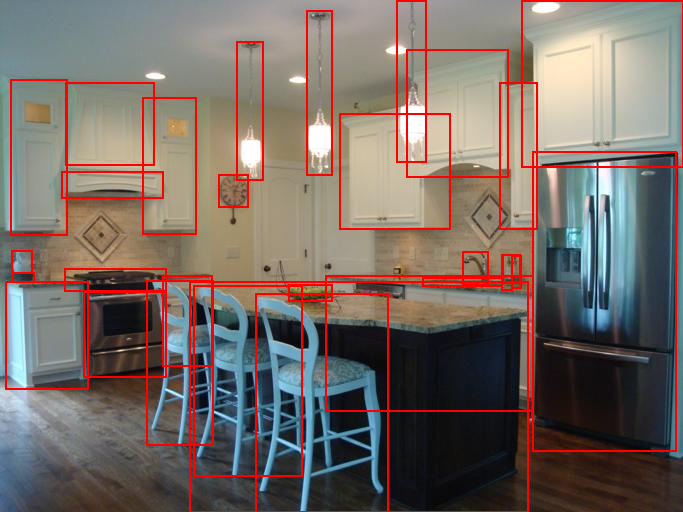

In [10]:
from PIL import Image, ImageDraw

def draw_bboxes(image, bboxes, color = "red", thickness = 2):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        bbox = tuple(map(int, bbox))  # 将浮点数类型的坐标转换为整数类型
        draw.rectangle(bbox, outline=color, width=thickness)
    del draw

# 示例用法
image_path = "demo.jpg"
bboxes = [
    (236, 41, 263, 180), (218, 174, 248, 207), (306, 10, 332, 175), (396, 0, 426, 162),
    (189, 281, 528, 512), (255, 293, 388, 512), (193, 285, 302, 476),
    (146, 280, 213, 445), (339, 113, 450, 229), (406, 49, 508, 177), (499, 82, 537, 229),
    (521, 0, 683, 167), (5, 281, 88, 389), (162, 275, 212, 366), (10, 79, 67, 235),
    (142, 97, 196, 234), (325, 275, 533, 411), (65, 82, 154, 165), (462, 251, 488, 285),
    (422, 277, 502, 286), (501, 254, 512, 290), (511, 255, 521, 288), (532, 151, 676, 451),
    (61, 171, 163, 198), (64, 268, 166, 291), (83, 291, 166, 377), (502, 254, 520, 283),
    (11, 250, 32, 273), (12, 272, 34, 282), (288, 284, 332, 301)
]

image = Image.open(image_path).convert("RGB")
draw_bboxes(image, bboxes)

image.show()

## GT框和SAM预测框的结果可视化

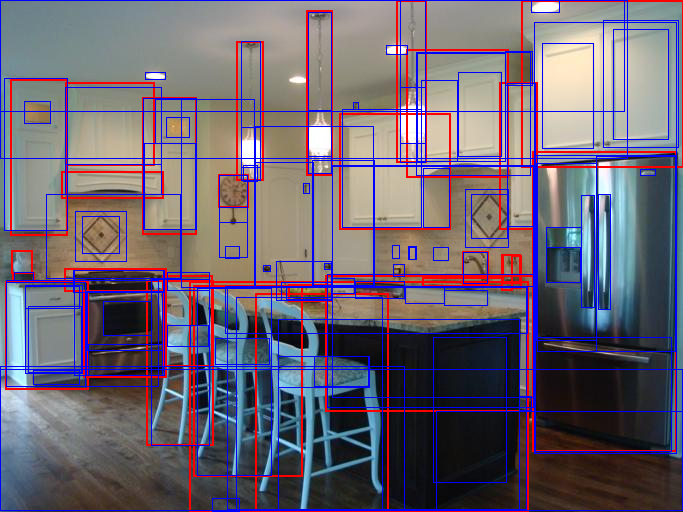

In [15]:
def draw_bboxes(image, bboxes, color = "red", thickness = 2):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        bbox = tuple(map(int, bbox))  # 将浮点数类型的坐标转换为整数类型
        draw.rectangle(bbox, outline=color, width=thickness)
    del draw

def draw_bboxes_2(image, bboxes, color = "blue", thickness = 1):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        bbox = tuple(map(int, bbox))  # 将浮点数类型的坐标转换为整数类型
        draw.rectangle(bbox, outline=color, width=thickness)
    del draw

# 示例用法
image_path = "demo.jpg"
bboxes = [
    (236, 41, 263, 180), (218, 174, 248, 207), (306, 10, 332, 175), (396, 0, 426, 162),
    (189, 281, 528, 512), (255, 293, 388, 512), (193, 285, 302, 476),
    (146, 280, 213, 445), (339, 113, 450, 229), (406, 49, 508, 177), (499, 82, 537, 229),
    (521, 0, 683, 167), (5, 281, 88, 389), (162, 275, 212, 366), (10, 79, 67, 235),
    (142, 97, 196, 234), (325, 275, 533, 411), (65, 82, 154, 165), (462, 251, 488, 285),
    (422, 277, 502, 286), (501, 254, 512, 290), (511, 255, 521, 288), (532, 151, 676, 451),
    (61, 171, 163, 198), (64, 268, 166, 291), (83, 291, 166, 377), (502, 254, 520, 283),
    (11, 250, 32, 273), (12, 272, 34, 282), (288, 284, 332, 301)
]

image = Image.open(image_path).convert("RGB")
draw_bboxes(image, bboxes)
draw_bboxes_2(image, bbox_list)

image.show()

## 根据IoU值来进行

In [25]:
def calculate_iou(bbox1, bbox2):
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2

    # 计算两个边界框的相交部分
    x_min = max(x1_min, x2_min)
    y_min = max(y1_min, y2_min)
    x_max = min(x1_max, x2_max)
    y_max = min(y1_max, y2_max)

    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)

    # 计算两个边界框的面积
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    # 计算 IoU
    iou = intersection / (area1 + area2 - intersection)

    return iou

bboxes = [
    (236, 41, 263, 180), (218, 174, 248, 207), (306, 10, 332, 175), (396, 0, 426, 162),
    (189, 281, 528, 512), (255, 293, 388, 512), (193, 285, 302, 476),
    (146, 280, 213, 445), (339, 113, 450, 229), (406, 49, 508, 177), (499, 82, 537, 229),
    (521, 0, 683, 167), (5, 281, 88, 389), (162, 275, 212, 366), (10, 79, 67, 235),
    (142, 97, 196, 234), (325, 275, 533, 411), (65, 82, 154, 165), (462, 251, 488, 285),
    (422, 277, 502, 286), (501, 254, 512, 290), (511, 255, 521, 288), (532, 151, 676, 451),
    (61, 171, 163, 198), (64, 268, 166, 291), (83, 291, 166, 377), (502, 254, 520, 283),
    (11, 250, 32, 273), (12, 272, 34, 282), (288, 284, 332, 301)
]

selected_bboxes = []
for pred_bbox in bbox_list:
    for gt_bbox in bboxes:
        iou_scores = [calculate_iou(pred_bbox, gt_bbox) for gt_bbox in bboxes]
        max_iou = max(iou_scores)
        if max_iou > 0.4:
            selected_bboxes.append(pred_bbox)

print(selected_bboxes)

[(534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (534, 22, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 453), (535, 155, 676, 4

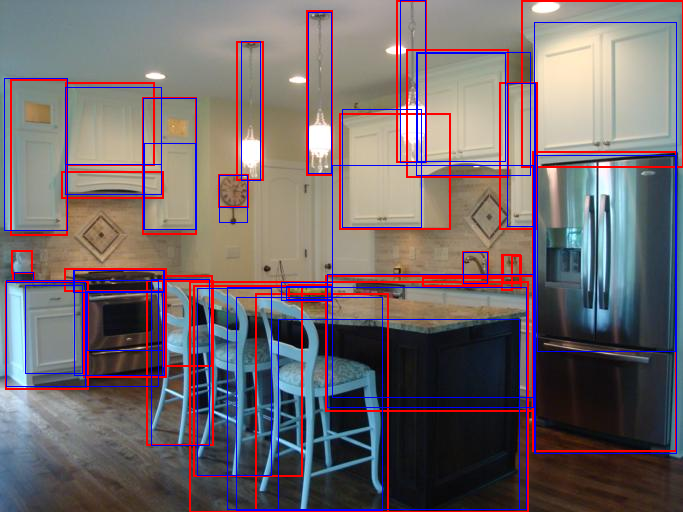

In [26]:
def draw_bboxes(image, bboxes, color = "red", thickness = 2):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        bbox = tuple(map(int, bbox))  # 将浮点数类型的坐标转换为整数类型
        draw.rectangle(bbox, outline=color, width=thickness)
    del draw

def draw_bboxes_2(image, bboxes, color = "blue", thickness = 1):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        bbox = tuple(map(int, bbox))  # 将浮点数类型的坐标转换为整数类型
        draw.rectangle(bbox, outline=color, width=thickness)
    del draw

# 示例用法
image_path = "demo.jpg"
bboxes = [
    (236, 41, 263, 180), (218, 174, 248, 207), (306, 10, 332, 175), (396, 0, 426, 162),
    (189, 281, 528, 512), (255, 293, 388, 512), (193, 285, 302, 476),
    (146, 280, 213, 445), (339, 113, 450, 229), (406, 49, 508, 177), (499, 82, 537, 229),
    (521, 0, 683, 167), (5, 281, 88, 389), (162, 275, 212, 366), (10, 79, 67, 235),
    (142, 97, 196, 234), (325, 275, 533, 411), (65, 82, 154, 165), (462, 251, 488, 285),
    (422, 277, 502, 286), (501, 254, 512, 290), (511, 255, 521, 288), (532, 151, 676, 451),
    (61, 171, 163, 198), (64, 268, 166, 291), (83, 291, 166, 377), (502, 254, 520, 283),
    (11, 250, 32, 273), (12, 272, 34, 282), (288, 284, 332, 301)
]

image = Image.open(image_path).convert("RGB")
draw_bboxes(image, bboxes)
draw_bboxes_2(image, selected_bboxes)

image.show()